# NOTE: CODE NEEDS TO BE RUN IN ORDER

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score
from sklearn.feature_selection import f_regression, mutual_info_regression 
from sklearn.preprocessing import LabelEncoder

In [2]:
housing = pd.read_csv('./data/Ames_HousePrice.csv', index_col=0)
housing['PricePerGLA'] = housing['SalePrice'] / housing['GrLivArea']
pd.set_option('display.max_columns', housing.shape[1])
addl_features = pd.read_csv('./data/data3_sub_w_nnprice.csv')[['PID', 'nn5meanprice', 'nn5medprice']]
housing = pd.merge(housing, addl_features, on = 'PID')
housing.sample(10)

PID  GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  \
1746  921205070       2482     281213          60       RL         88.0   
2386  528366040       2799     315000          60       RL          NaN   
1712  535153140       1440     185000          20       RL         82.0   
2213  902109130       1701      94550         190       RM         63.0   
895   535354260       1728     156000          50       RL          NaN   
1875  528280100       1886     199900          60       RL          NaN   
529   906475070       2126     185000          60       RL          NaN   
327   905425125       2358     240000          50       RL         75.0   
1134  908151050       1426     159500          60       RL         75.0   
1177  528315030       2392     348000          60       RL         82.0   

      LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
1746    12665   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
2386    12585   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
1712     9840   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
2213     7627   Pave   NaN      Reg         Lvl    AllPub    Corner       Gtl   
895     12099   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
1875    11214   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl   
529     28698   Pave   NaN      IR2         Low    AllPub   CulDSac       Sev   
327     45600   Pave   NaN      IR2         Bnk    AllPub    Inside       Gtl   
1134     7950   Pave   NaN      IR1         Bnk    AllPub    Corner       Gtl   
1177     9452   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   

     Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  \
1746       Timber       Norm       Norm     1Fam     2Story            8   
2386      NoRidge       Norm       Norm     1Fam     2Story            8   
1712        NAmes       Norm       Norm     1Fam     1Story            5   
2213      OldTown     Artery       Norm   2fmCon     2Story            4   
895         NAmes       Norm       Norm     1Fam     1.5Fin            5   
1875      Gilbert       Norm       Norm     1Fam     2Story            7   
529       ClearCr       Norm       Norm     1Fam     2Story            5   
327       ClearCr       Norm       Norm     1Fam     1.5Fin            6   
1134      Edwards       Norm       Norm     1Fam     2Story            6   
1177      NoRidge       Norm       Norm     1Fam     2Story            8   

      OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st  \
1746            5       2005          2006       Hip  CompShg     VinylSd   
2386            5       1993          1993     Gable  CompShg     HdBoard   
1712            7       1959          1998     Gable  CompShg     HdBoard   
2213            6       1920          1950     Gable  CompShg     AsbShng   
895             6       1953          2004     Gable  CompShg     MetalSd   
1875            5       1998          1999     Gable  CompShg     VinylSd   
529             5       1967          1967      Flat  Tar&Grv     Plywood   
327             8       1908          1997     Gable  CompShg     Wd Sdng   
1134            6       1977          1977       Hip  CompShg     HdBoard   
1177            5       1997          1998     Gable  CompShg     VinylSd   

     Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation  \
1746     VinylSd    BrkFace       245.0        Gd        TA      PConc   
2386     ImStucc    BrkFace       420.0        Gd        TA      PConc   
1712     HdBoard       None         0.0        TA        TA     CBlock   
2213     AsbShng       None         0.0        Fa        TA     BrkTil   
895      MetalSd       None         0.0        TA        TA     CBlock   
1875     VinylSd       None         0.0        Gd        TA      PConc   
529      Plywood       None         0.0        TA        TA      PConc   
327      Wd Sdng 

# Initial Cut Based On EDA

In [3]:
# Primary: (MSSubClass, HouseStyle, BldgType), MsZoning, LandContour, LotConfig, Neighborhood, Condition1, YearBuilt, 
# YearRemodAdd (binary categorical variable of 1 or 0 on remodeling), RoofStyle, (Exterior1st, Exterior2nd, 
# MasVnrType, ExterQual, ExterCond), Foundation, (BsmtQual, BsmtCond, BsmtFinType1, BsmtFinSF1, TotalBsmtSF), HeatingQC, 
# CentralAir, Electrical, (1stFlrSF, 2ndFlrSF), (BsmtFullBath, FullBath, HalfBath), (BedroomAbvGr, TotRmsAbvGrd), 
# (KitchenAbvGr, KitchenQual), (GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond,
# PavedDrive), MoSold, SaleType, SaleCondition

In [4]:
# Secondary: Alley, LotShape, LandSlope, OverallQual, OverallCond, BsmtExposure, Functional, FireplaceQu

# Features After Unary F-tests and Mutual Information

In [5]:
label_encoder = LabelEncoder()
housing_temp = housing.copy()
housing_temp.drop(['PID', 'SalePrice', 'LotFrontage'], axis = 1, inplace= True)

housing_temp['YearRemodAdd'] = (housing_temp['YearBuilt'] != housing_temp['YearRemodAdd']).map(int)

cat_features_with_NA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
                   'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for feature in cat_features_with_NA:
    housing_temp[feature].fillna('NA', inplace = True)
housing_temp = housing_temp[~housing_temp.isnull().any(axis = 1)]

features_to_be_encoded = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
                         'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
                         'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 
                         'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 
                          'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                          'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 
                          'SaleCondition']
for feature in features_to_be_encoded:
    housing_temp[feature] = label_encoder.fit_transform(housing_temp[feature])

value_f, p_f = f_regression(housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'], housing_temp['PricePerGLA'])
mutual_scores = mutual_info_regression(housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'],
                                       housing_temp['PricePerGLA'])

In [6]:
p_values = pd.Series(p_f, index = housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'].columns).sort_values()
p_values.head(20)

nn5meanprice    7.037008e-280
nn5medprice     3.193762e-258
YearBuilt       1.229616e-173
OverallQual     3.240157e-143
BsmtFinSF1      3.878930e-137
GarageYrBlt     2.680716e-133
TotalBsmtSF     4.371840e-132
ExterQual       2.054707e-131
KitchenQual     1.206228e-103
BsmtExposure     1.150385e-94
BsmtQual         1.725559e-93
BsmtFullBath     1.806311e-91
2ndFlrSF         5.571787e-88
BedroomAbvGr     4.314049e-85
GarageFinish     7.706167e-69
GarageArea       2.225151e-67
GarageCars       3.535205e-61
1stFlrSF         1.122326e-58
GarageType       7.014006e-58
BsmtFinType1     2.299695e-52
dtype: float64

In [7]:
mutual_score_values = pd.Series(mutual_scores, 
        index = housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'].columns).sort_values(ascending = False)
mutual_score_values.head(20)

nn5medprice     0.322105
nn5meanprice    0.318674
Neighborhood    0.300819
MSSubClass      0.296015
YearBuilt       0.263105
GarageYrBlt     0.214490
2ndFlrSF        0.199590
TotalBsmtSF     0.198070
BsmtQual        0.189783
BsmtFinSF1      0.187072
HouseStyle      0.183672
BsmtFinType1    0.183356
OverallQual     0.175686
ExterQual       0.148485
1stFlrSF        0.143330
BsmtExposure    0.131442
GrLivArea       0.117706
Exterior2nd     0.116291
KitchenQual     0.111210
Exterior1st     0.111180
dtype: float64

# Features After Comparing R2 From Simple Linear Regression 

In [8]:
# Test R2 > 0.1: MsSubClass, HouseStyle, MSZoning, Neighborhood, YearBuilt, ExterQual, Foundation, BsmtQual, BsmtFinType1, 
#                BsmtFinSF1, TotalBsmtSF, BsmtFullBath, BedroomAbvGr, KitchenQual, GarageType, GarageYrBlt, GarageFinish,
#                GarageCars, nn5medprice, nn5meanprice

# Potentials: HeatingQC, Exterior1st/Exterior2nd

In [9]:
# Test R2 > 0.15: MsSubClass, HouseStyle, Neighborhood, YearBuilt, ExterQual, Foundation, BsmtQual, BsmtFinType1, 
#                BsmtFinSF1, TotalBsmtSF, BsmtFullBath, BedroomAbvGr, KitchenQual, GarageYrBlt, GarageCars, nn5medprice,
#                nn5meanprice

In [10]:
# Test R2 > 0.2: MsSubClass, HouseStyle, Neighborhood, YearBuilt, ExterQual, BsmtQual, BsmtFinType1, KitchenQual,
#               GarageYrBlt, nn5medprice, nn5meanprice

# Best Features

In [11]:
# MSSubClass, HouseStyle, Neighborhood, YearBuilt, ExterQual, Foundation, BsmtQual, BsmtFinType1, BsmtFinSF1, TotalBsmtSF, 
# BsmtFullBath, BedroomAbvGr, KitchenQual, GarageYrBlt, GarageCars, nn5meanprice, nn5medprice

In [12]:
housing_temp = housing[['MSSubClass', 'HouseStyle', 'Neighborhood', 'YearBuilt', 'ExterQual', 'Foundation', 'BsmtQual', 
                        'BsmtFinType1', 'BsmtFinSF1', 'TotalBsmtSF', 'BsmtFullBath', 'BedroomAbvGr', 'KitchenQual', 
                        'GarageYrBlt', 'GarageCars', 'nn5medprice', 'nn5meanprice', 'PricePerGLA']].copy()

# Clean up data
MSSubClass = pd.get_dummies(housing_temp['MSSubClass'], prefix = 'MSSubClass')
MSSubClass.drop('MSSubClass_' + str(housing_temp['MSSubClass'].mode()[0]), axis = 1, inplace = True)
housing_temp = housing_temp.drop('MSSubClass', axis = 1)
housing_temp = pd.concat([housing_temp, MSSubClass], axis = 1)

HouseStyle = pd.get_dummies(housing_temp['HouseStyle'], prefix = 'HouseStyle')
HouseStyle.drop('HouseStyle_' + str(housing_temp['HouseStyle'].mode()[0]), axis = 1, inplace = True)
housing_temp = housing_temp.drop('HouseStyle', axis = 1)
housing_temp = pd.concat([housing_temp, HouseStyle], axis = 1)

Neighborhood = pd.get_dummies(housing_temp['Neighborhood'], prefix = 'Neighborhood')
Neighborhood.drop('Neighborhood_' + str(housing_temp['Neighborhood'].mode()[0]), axis = 1, inplace = True)
housing_temp = housing_temp.drop('Neighborhood', axis = 1)
housing_temp = pd.concat([housing_temp, Neighborhood], axis = 1)

ExterQual = pd.get_dummies(housing_temp['ExterQual'], prefix = 'ExterQual')
ExterQual.drop('ExterQual_' + str(housing_temp['ExterQual'].mode()[0]), axis = 1, inplace = True)
housing_temp = housing_temp.drop('ExterQual', axis = 1)
housing_temp = pd.concat([housing_temp, ExterQual], axis = 1)

Foundation = pd.get_dummies(housing_temp['Foundation'], prefix = 'Foundation')
Foundation.drop('Foundation_' + str(housing_temp['Foundation'].mode()[0]), axis = 1, inplace = True)
housing_temp = housing_temp.drop('Foundation', axis = 1)
housing_temp = pd.concat([housing_temp, Foundation], axis = 1)

BsmtQual = pd.get_dummies(housing_temp[~housing_temp['BsmtQual'].isnull()]['BsmtQual'], prefix = 'BsmtQual')
BsmtQual.drop('BsmtQual_' + str(housing_temp[~housing_temp['BsmtQual'].isnull()]['BsmtQual'].mode()[0]),
              axis = 1, inplace = True)
housing_temp = housing_temp[~housing_temp['BsmtQual'].isnull()].drop('BsmtQual', axis = 1)
housing_temp = pd.concat([housing_temp, BsmtQual], axis = 1)

BsmtFinType1 = pd.get_dummies(housing_temp[~housing_temp['BsmtFinType1'].isnull()]['BsmtFinType1'],
                              prefix = 'BsmtFinType1')
BsmtFinType1.drop('BsmtFinType1_' + str(housing_temp[~housing_temp['BsmtFinType1'].isnull()]['BsmtFinType1'].mode()[0]),
                  axis = 1, inplace = True)
housing_temp = housing_temp[~housing_temp['BsmtFinType1'].isnull()].drop('BsmtFinType1', axis = 1)
housing_temp = pd.concat([housing_temp, BsmtFinType1], axis = 1)

KitchenQual = pd.get_dummies(housing_temp['KitchenQual'], prefix = 'KitchenQual')
KitchenQual.drop('KitchenQual_' + str(housing_temp['KitchenQual'].mode()[0]), axis = 1, inplace = True)
housing_temp = housing_temp.drop('KitchenQual', axis = 1)
housing_temp = pd.concat([housing_temp, KitchenQual], axis = 1)

housing_temp = housing_temp[~housing_temp.isnull().any(axis = 1)].reset_index().drop('index', axis = 1)

In [13]:
regression = LinearRegression()
k5 = KFold(n_splits=5)
train_R2 = []
test_R2 = []

for train_index, test_index in k5.split(housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'], 
                                        housing_temp['PricePerGLA']):
    x_train = housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'].iloc[train_index]
    y_train = housing_temp['PricePerGLA'][train_index]
    x_test = housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'].iloc[test_index]
    y_test = housing_temp['PricePerGLA'][test_index]
    regression.fit(x_train, y_train)
    train_R2.append(regression.score(x_train, y_train))
    test_R2.append(regression.score(x_test, y_test))

print(f'Train R2: {np.array(train_R2).mean(): .3}')
print(f'Test R2: {np.array(test_R2).mean(): .3}')

Train R2:  0.753
Test R2:  0.719


# Lasso Penalization

In [14]:
lasso  = Lasso()
alphas = np.linspace(0.1, 20.1, 21)
lasso.set_params(normalize = False)
coefs_lasso  = []

for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'], housing_temp['PricePerGLA'])  
    coefs_lasso.append(lasso.coef_)

coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, 
                           columns = housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'].columns)  
coefs_lasso

YearBuilt  BsmtFinSF1  TotalBsmtSF  BsmtFullBath  BedroomAbvGr  \
0.1    0.217782    0.009356    -0.004309      2.239463     -8.248747   
1.1    0.118808    0.014905     0.006802      0.000000     -9.297840   
2.1    0.096316    0.015484     0.008379      0.000000     -8.594113   
3.1    0.094527    0.016057     0.007690      0.000000     -6.897846   
4.1    0.092754    0.016631     0.007001      0.000000     -5.201379   
5.1    0.090981    0.017204     0.006312      0.000000     -3.504906   
6.1    0.089197    0.017778     0.005624      0.000000     -1.808574   
7.1    0.087427    0.018351     0.004934      0.000000     -0.112062   
8.1    0.087772    0.018397     0.004943      0.000000     -0.000000   
9.1    0.088262    0.018406     0.005000      0.000000     -0.000000   
10.1   0.088753    0.018415     0.005058      0.000000     -0.000000   
11.1   0.089244    0.018423     0.005116      0.000000     -0.000000   
12.1   0.089734    0.018432     0.005173      0.000000     -0.000000   
13.1   0.090225    0.018441     0.005231      0.000000     -0.000000   
14.1   0.090715    0.018450     0.005289      0.000000     -0.000000   
15.1   0.091206    0.018458     0.005346      0.000000     -0.000000   
16.1   0.091697    0.018467     0.005404      0.000000     -0.000000   
17.1   0.092187    0.018476     0.005461      0.000000     -0.000000   
18.1   0.092678    0.018484     0.005519      0.000000     -0.000000   
19.1   0.093168    0.018493     0.005577      0.000000     -0.000000   
20.1   0.093659    0.018502     0.005634      0.000000     -0.000000   

      GarageYrBlt  GarageCars  nn5medprice  nn5meanprice  MSSubClass_30  \
0.1      0.056188    1.650778     0.091277      0.228940            0.0   
1.1      0.102878    0.000000     0.095654      0.384415            0.0   
2.1      0.089490    0.000000     0.106716      0.389705            0.0   
3.1      0.088139   -0.000000     0.112892      0.393352            0.0   
4.1      0.086781   -0.000000     0.119537      0.396517            0.0   
5.1      0.085423   -0.000000     0.126196      0.399668            0.0   
6.1      0.084070   -0.000000     0.132524      0.403158            0.0   
7.1      0.082710   -0.000000     0.139274      0.406216            0.0   
8.1      0.081321   -0.000000     0.140027      0.404298            0.0   
9.1      0.079932   -0.000000     0.140251      0.402135            0.0   
10.1     0.078543   -0.000000     0.140476      0.399973            0.0   
11.1     0.077155   -0.000000     0.140701      0.397810            0.0   
12.1     0.075766   -0.000000     0.140925      0.395647            0.0   
13.1     0.074377   -0.000000     0.141150      0.393485            0.0   
14.1     0.072988   -0.000000     0.141374      0.391322            0.0   
15.1     0.071599   -0.000000     0.141599      0.389160            0.0   
16.1     0.070210   -0.000000     0.141823      0.386998            0.0   
17.1     0.068821   -0.000000     0.142048      0.384835            0.0   
18.1     0.067432   -0.000000     0.142272      0.382673            0.0   
19.1     0.066044   -0.000000     0.142496      0.380511            0.0   
20.1     0.064655   -0.000000     0.142721      0.378348            0.0   

      MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  \
0.1            -0.0            0.0           -0.0        -6.4239   
1.1             0.0            0.0           -0.0        -0.0000   
2.1             0.0            0.0           -0.0        -0.0000   
3.1             0.0            0.0           -0.0        -0.0000   
4.1             0.0            0.0           -0.0        -0.0000   
5.1             0.0            0.0           -0.0        -0.0000   
6.1             0.0            0.0           -0.0        -0.0000   
7.1             0.0            0.0           -0.0        -0.0000   
8.1             0.0            0.0           -0.0        -0.0000   
9.1             0.0            0.0           -0.0        -0.0000   
10.1            0.0   

In [15]:
# All the dummified categorial variables drop off pretty quickly
# Could drop BsmtFullBath, GaraegCars

# Multicollinearity for Continuous Features

In [16]:
continuous_features = ['YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF', 'GarageYrBlt', 'nn5medprice', 'nn5meanprice']
scores = {}
ols = LinearRegression()
for feature in continuous_features:
    housing_temp = housing[~housing[continuous_features].isnull().any(axis = 1)][continuous_features].copy()
    feature_col = housing_temp[feature].copy()
    housing_temp.drop(feature, axis=1, inplace=True)
    ols.fit(housing_temp, feature_col)
    scores[feature] = ols.score(housing_temp, feature_col)   

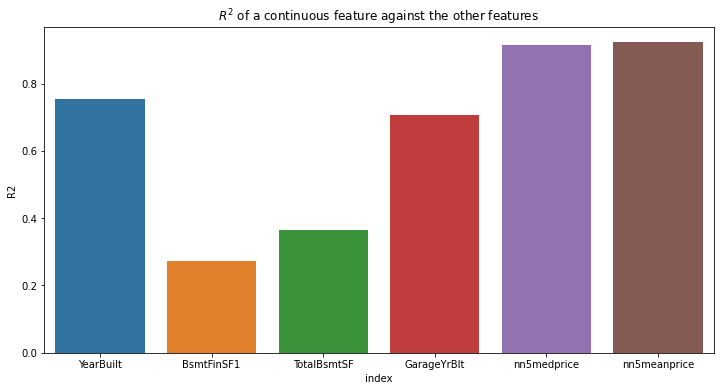

In [17]:
plt.figure(figsize = (12, 6))
sns.barplot(x='index', y='R2', data=pd.DataFrame(scores, index=['R2']).T.reset_index())
plt.title('$R^2$ of a continuous feature against the other features');

In [18]:
# Drop GarageYrBlt since its R2, p-value for F-test, and mutual information score is worse than YearBuilt.
# Drop nn5medprice since its R2, p-value for F-test, and mutual information score is slightly worse than nn5meanprice.

# Final Regression

In [19]:
housing_temp = housing[['MSSubClass', 'HouseStyle', 'Neighborhood', 'YearBuilt', 'ExterQual', 'Foundation', 'BsmtQual', 
                        'BsmtFinType1', 'BsmtFinSF1', 'TotalBsmtSF', 'BedroomAbvGr', 'KitchenQual', 'nn5meanprice',
                        'PricePerGLA']].copy()

# Clean up data
MSSubClass = pd.get_dummies(housing_temp['MSSubClass'], prefix = 'MSSubClass')
MSSubClass.drop('MSSubClass_' + str(housing_temp['MSSubClass'].mode()[0]), axis = 1, inplace = True)
housing_temp = housing_temp.drop('MSSubClass', axis = 1)
housing_temp = pd.concat([housing_temp, MSSubClass], axis = 1)

HouseStyle = pd.get_dummies(housing_temp['HouseStyle'], prefix = 'HouseStyle')
HouseStyle.drop('HouseStyle_' + str(housing_temp['HouseStyle'].mode()[0]), axis = 1, inplace = True)
housing_temp = housing_temp.drop('HouseStyle', axis = 1)
housing_temp = pd.concat([housing_temp, HouseStyle], axis = 1)

Neighborhood = pd.get_dummies(housing_temp['Neighborhood'], prefix = 'Neighborhood')
Neighborhood.drop('Neighborhood_' + str(housing_temp['Neighborhood'].mode()[0]), axis = 1, inplace = True)
housing_temp = housing_temp.drop('Neighborhood', axis = 1)
housing_temp = pd.concat([housing_temp, Neighborhood], axis = 1)

ExterQual = pd.get_dummies(housing_temp['ExterQual'], prefix = 'ExterQual')
ExterQual.drop('ExterQual_' + str(housing_temp['ExterQual'].mode()[0]), axis = 1, inplace = True)
housing_temp = housing_temp.drop('ExterQual', axis = 1)
housing_temp = pd.concat([housing_temp, ExterQual], axis = 1)

Foundation = pd.get_dummies(housing_temp['Foundation'], prefix = 'Foundation')
Foundation.drop('Foundation_' + str(housing_temp['Foundation'].mode()[0]), axis = 1, inplace = True)
housing_temp = housing_temp.drop('Foundation', axis = 1)
housing_temp = pd.concat([housing_temp, Foundation], axis = 1)

BsmtQual = pd.get_dummies(housing_temp[~housing_temp['BsmtQual'].isnull()]['BsmtQual'], prefix = 'BsmtQual')
BsmtQual.drop('BsmtQual_' + str(housing_temp[~housing_temp['BsmtQual'].isnull()]['BsmtQual'].mode()[0]),
              axis = 1, inplace = True)
housing_temp = housing_temp[~housing_temp['BsmtQual'].isnull()].drop('BsmtQual', axis = 1)
housing_temp = pd.concat([housing_temp, BsmtQual], axis = 1)

BsmtFinType1 = pd.get_dummies(housing_temp[~housing_temp['BsmtFinType1'].isnull()]['BsmtFinType1'],
                              prefix = 'BsmtFinType1')
BsmtFinType1.drop('BsmtFinType1_' + str(housing_temp[~housing_temp['BsmtFinType1'].isnull()]['BsmtFinType1'].mode()[0]),
                  axis = 1, inplace = True)
housing_temp = housing_temp[~housing_temp['BsmtFinType1'].isnull()].drop('BsmtFinType1', axis = 1)
housing_temp = pd.concat([housing_temp, BsmtFinType1], axis = 1)

KitchenQual = pd.get_dummies(housing_temp['KitchenQual'], prefix = 'KitchenQual')
KitchenQual.drop('KitchenQual_' + str(housing_temp['KitchenQual'].mode()[0]), axis = 1, inplace = True)
housing_temp = housing_temp.drop('KitchenQual', axis = 1)
housing_temp = pd.concat([housing_temp, KitchenQual], axis = 1)

housing_temp = housing_temp[~housing_temp.isnull().any(axis = 1)].reset_index().drop('index', axis = 1)

In [20]:
regression = LinearRegression()
k5 = KFold(n_splits=5)
train_R2 = []
test_R2 = []

for train_index, test_index in k5.split(housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'], 
                                        housing_temp['PricePerGLA']):
    x_train = housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'].iloc[train_index]
    y_train = housing_temp['PricePerGLA'][train_index]
    x_test = housing_temp.loc[:, housing_temp.columns != 'PricePerGLA'].iloc[test_index]
    y_test = housing_temp['PricePerGLA'][test_index]
    regression.fit(x_train, y_train)
    train_R2.append(regression.score(x_train, y_train))
    test_R2.append(regression.score(x_test, y_test))

print(f'Train R2: {np.array(train_R2).mean(): .3}')
print(f'Test R2: {np.array(test_R2).mean(): .3}')

Train R2:  0.751
Test R2:  0.72


In [21]:
# Feature intreaction? 

# APPENDIX: R2 CALCULATION FOR EACH FEATURE

# nn5medprice

In [22]:
housing_temp = housing[~housing['nn5medprice'].isnull()][['PricePerGLA', 'nn5medprice']]
housing_temp

PricePerGLA  nn5medprice
0      147.196262    87.774295
1      132.983794    99.408284
2      124.775225    65.393093
3      109.720885   120.694444
4      136.336336   120.274914
...           ...          ...
2555   127.100840    88.902980
2556    80.553953   130.434783
2557    72.427572    91.082317
2558   118.078176   117.469880
2559   112.506541   118.564356

[2495 rows x 2 columns]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.383
Test R2: 0.413


# nn5meanprice

In [24]:
housing_temp = housing[~housing['nn5meanprice'].isnull()][['PricePerGLA', 'nn5meanprice']]
housing_temp

PricePerGLA  nn5meanprice
0      147.196262     90.569952
1      132.983794    120.315223
2      124.775225     72.928680
3      109.720885    124.945633
4      136.336336    119.003791
...           ...           ...
2555   127.100840     93.312424
2556    80.553953    127.856188
2557    72.427572     96.250071
2558   118.078176    119.542978
2559   112.506541    118.728788

[2495 rows x 2 columns]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.405
Test R2: 0.456


# MSSubClass

In [26]:
MSSubClass = pd.get_dummies(housing['MSSubClass'], prefix = 'MSSubClass')
MSSubClass.drop('MSSubClass_' + str(housing['MSSubClass'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], MSSubClass], axis = 1)
housing_temp

PricePerGLA  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  \
0      147.196262              1              0              0              0   
1      132.983794              0              0              0              0   
2      124.775225              1              0              0              0   
3      109.720885              0              0              0              0   
4      136.336336              0              0              0              0   
...           ...            ...            ...            ...            ...   
2555   127.100840              1              0              0              0   
2556    80.553953              0              0              0              0   
2557    72.427572              0              0              0              0   
2558   118.078176              0              0              0              0   
2559   112.506541              0              0              0              0   

      MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              1              0              0   
4                 1              0              0              0   
...             ...            ...            ...            ...   
2555              0              0              0              0   
2556              0              0              0              0   
2557              0              0              0              0   
2558              1              0              0              0   
2559              1              0              0              0   

      MSSubClass_85  MSSubClass_90  MSSubClass_120  MSSubClass_150  \
0                 0              0               0               0   
1                 0              0               1               0   
2                 0              0               0               0   
3                 0              0               0               0   
4                 0              0               0               0   
...             ...            ...             ...             ...   
2555              0              0               0               0   
2556              0              0               0               0   
2557              0              1               0               0   
2558              0              0               0               0   
2559              0              0               0               0   

      MSSubClass_160  MSSubClass_180  MSSubClass_190  
0                  0               0               0  
1                  0               0               0  
2                  0               0               0  
3                  0               0               0  
4                  0               0               0  
...              ...             ...             ...  
2555               0               0               0  
2556               0               0               0  
2557               0               0               0  
2558               0               0               0  
2559               0               0               0  

[2560 rows x 16 columns]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.390
Test R2: 0.387


# HouseStyle

In [28]:
HouseStyle = pd.get_dummies(housing['HouseStyle'], prefix = 'HouseStyle')
HouseStyle.drop('HouseStyle_' + str(housing['HouseStyle'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], HouseStyle], axis = 1)
housing_temp

PricePerGLA  HouseStyle_1.5Fin  HouseStyle_1.5Unf  HouseStyle_2.5Fin  \
0      147.196262                  0                  0                  0   
1      132.983794                  0                  0                  0   
2      124.775225                  0                  0                  0   
3      109.720885                  0                  0                  0   
4      136.336336                  0                  0                  0   
...           ...                ...                ...                ...   
2555   127.100840                  0                  1                  0   
2556    80.553953                  0                  0                  0   
2557    72.427572                  0                  0                  0   
2558   118.078176                  0                  0                  0   
2559   112.506541                  0                  0                  0   

      HouseStyle_2.5Unf  HouseStyle_2Story  HouseStyle_SFoyer  HouseStyle_SLvl  
0                     0                  0                  0                0  
1                     0                  0                  0                0  
2                     0                  0                  0                0  
3                     0                  1                  0                0  
4                     0                  1                  0                0  
...                 ...                ...                ...              ...  
2555                  0                  0                  0                0  
2556                  0                  0                  0                0  
2557                  0                  1                  0                0  
2558                  0                  1                  0                0  
2559                  0                  1                  0                0  

[2560 rows x 8 columns]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.259
Test R2: 0.247


# BldgType

In [30]:
BldgType = pd.get_dummies(housing['BldgType'], prefix = 'BldgType')
BldgType.drop('BldgType_' + str(housing['BldgType'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], BldgType], axis = 1)
housing_temp

PricePerGLA  BldgType_2fmCon  BldgType_Duplex  BldgType_Twnhs  \
0      147.196262                0                0               0   
1      132.983794                0                0               0   
2      124.775225                0                0               0   
3      109.720885                0                0               0   
4      136.336336                0                0               0   
...           ...              ...              ...             ...   
2555   127.100840                0                0               0   
2556    80.553953                0                0               0   
2557    72.427572                0                1               0   
2558   118.078176                0                0               0   
2559   112.506541                0                0               0   

      BldgType_TwnhsE  
0                   0  
1                   1  
2                   0  
3                   0  
4                   0  
...               ...  
2555                0  
2556                0  
2557                0  
2558                0  
2559                0  

[2560 rows x 5 columns]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.106
Test R2: 0.086


# MSZoning

In [32]:
MSZoning = pd.get_dummies(housing['MSZoning'], prefix = 'MSZoning')
MSZoning.drop('MSZoning_' + str(housing['MSZoning'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], MSZoning], axis = 1)
housing_temp

PricePerGLA  MSZoning_C (all)  MSZoning_FV  MSZoning_I (all)  \
0      147.196262                 0            0                 0   
1      132.983794                 0            0                 0   
2      124.775225                 1            0                 0   
3      109.720885                 0            0                 0   
4      136.336336                 0            0                 0   
...           ...               ...          ...               ...   
2555   127.100840                 0            0                 0   
2556    80.553953                 0            0                 0   
2557    72.427572                 0            0                 0   
2558   118.078176                 0            0                 0   
2559   112.506541                 0            0                 0   

      MSZoning_RH  MSZoning_RM  
0               0            0  
1               0            0  
2               0            0  
3               0            0  
4               0            0  
...           ...          ...  
2555            0            0  
2556            0            0  
2557            1            0  
2558            0            0  
2559            0            0  

[2560 rows x 6 columns]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.131
Test R2: 0.094


# LandContour

In [34]:
LandContour = pd.get_dummies(housing['LandContour'], prefix = 'LandContour')
LandContour.drop('LandContour_' + str(housing['LandContour'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], LandContour], axis = 1)
housing_temp

PricePerGLA  LandContour_Bnk  LandContour_HLS  LandContour_Low
0      147.196262                0                0                0
1      132.983794                0                0                0
2      124.775225                0                0                0
3      109.720885                0                0                0
4      136.336336                0                0                0
...           ...              ...              ...              ...
2555   127.100840                0                0                0
2556    80.553953                0                0                0
2557    72.427572                0                1                0
2558   118.078176                0                0                0
2559   112.506541                0                0                0

[2560 rows x 4 columns]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.031
Test R2: 0.061


# LotConfig

In [36]:
LotConfig = pd.get_dummies(housing['LotConfig'], prefix = 'LotConfig')
LotConfig.drop('LotConfig_' + str(housing['LotConfig'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], LotConfig], axis = 1)
housing_temp

PricePerGLA  LotConfig_Corner  LotConfig_CulDSac  LotConfig_FR2  \
0      147.196262                 1                  0              0   
1      132.983794                 0                  0              0   
2      124.775225                 0                  0              0   
3      109.720885                 1                  0              0   
4      136.336336                 0                  0              0   
...           ...               ...                ...            ...   
2555   127.100840                 0                  0              0   
2556    80.553953                 0                  1              0   
2557    72.427572                 0                  0              0   
2558   118.078176                 0                  0              0   
2559   112.506541                 0                  0              0   

      LotConfig_FR3  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
2555              0  
2556              0  
2557              0  
2558              0  
2559              0  

[2560 rows x 5 columns]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.012
Test R2: 0.020


# Neighborhood

In [38]:
Neighborhood = pd.get_dummies(housing['Neighborhood'], prefix = 'Neighborhood')
Neighborhood.drop('Neighborhood_' + str(housing['Neighborhood'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], Neighborhood], axis = 1)
housing_temp

PricePerGLA  Neighborhood_Blmngtn  Neighborhood_Blueste  \
0      147.196262                     0                     0   
1      132.983794                     0                     0   
2      124.775225                     0                     0   
3      109.720885                     0                     0   
4      136.336336                     0                     0   
...           ...                   ...                   ...   
2555   127.100840                     0                     0   
2556    80.553953                     0                     0   
2557    72.427572                     0                     0   
2558   118.078176                     0                     0   
2559   112.506541                     0                     0   

      Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  \
0                       0                     0                     0   
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     0                     0   
4                       0                     0                     0   
...                   ...                   ...                   ...   
2555                    0                     1                     0   
2556                    0                     0                     0   
2557                    0                     0                     0   
2558                    0                     0                     0   
2559                    0                     0                     0   

      Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Edwards  \
0                        0                     0                     0   
1                        0                     0                     1   
2                        0                     0                     0   
3                        0                     0                     0   
4                        0                     0                     0   
...                    ...                   ...                   ...   
2555                     0                     0                     0   
2556                     0                     0                     1   
2557                     0                     1                     0   
2558                     1                     0                     0   
2559                     0                     0                     0   

      Neighborhood_Gilbert  Neighborhood_Greens  Neighborhood_IDOTRR  \
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    0                    1   
3                        0                    0                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
2555                     0                    0                    0   
2556                     0                    0                    0   
2557                     0                    0                    0   
2558                     0                    0                    0   
2559                     0                    0                    0   

      Neighborhood_Landmrk  Neighborhood_MeadowV  Neighborhood_Mitchel  \
0                        0                     0                     0   
1                        0                     0                     0   
2                        0                     0                     0   
3                        0                     0                     0   
4                        0                     0                     0   
...                    ...                   ...                   ...   
2555                     0                     0                     0   
25

In [39]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.389
Test R2: 0.364


# Condition1

In [40]:
Condition1 = pd.get_dummies(housing['Condition1'], prefix = 'Condition1')
Condition1.drop('Condition1_' + str(housing['Condition1'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], Condition1], axis = 1)
housing_temp

PricePerGLA  Condition1_Artery  Condition1_Feedr  Condition1_PosA  \
0      147.196262                  0                 0                0   
1      132.983794                  0                 0                0   
2      124.775225                  0                 0                0   
3      109.720885                  0                 0                0   
4      136.336336                  0                 0                0   
...           ...                ...               ...              ...   
2555   127.100840                  0                 0                0   
2556    80.553953                  0                 0                0   
2557    72.427572                  0                 0                0   
2558   118.078176                  0                 0                0   
2559   112.506541                  0                 0                0   

      Condition1_PosN  Condition1_RRAe  Condition1_RRAn  Condition1_RRNe  \
0                   0                0                0                0   
1                   0                0                0                0   
2                   0                0                0                0   
3                   0                0                0                0   
4                   0                0                0                0   
...               ...              ...              ...              ...   
2555                0                0                0                0   
2556                0                0                0                0   
2557                0                0                0                0   
2558                0                0                0                0   
2559                0                0                0                0   

      Condition1_RRNn  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
2555                0  
2556                0  
2557                0  
2558                0  
2559                0  

[2560 rows x 9 columns]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.046
Test R2: 0.047


# YearBuilt

In [42]:
housing_temp = housing[['PricePerGLA', 'YearBuilt']]
housing_temp

PricePerGLA  YearBuilt
0      147.196262       1939
1      132.983794       1984
2      124.775225       1930
3      109.720885       1900
4      136.336336       2001
...           ...        ...
2555   127.100840       1916
2556    80.553953       1955
2557    72.427572       1949
2558   118.078176       2000
2559   112.506541       1993

[2560 rows x 2 columns]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.298
Test R2: 0.295


# YearRemodAdd

In [44]:
housing_temp = housing.copy()
housing_temp['Remod'] = (housing_temp['YearBuilt'] != housing_temp['YearRemodAdd']).map(int)
housing_temp = housing_temp[['PricePerGLA', 'Remod']]
housing_temp

PricePerGLA  Remod
0      147.196262      1
1      132.983794      0
2      124.775225      1
3      109.720885      1
4      136.336336      0
...           ...    ...
2555   127.100840      1
2556    80.553953      0
2557    72.427572      1
2558   118.078176      0
2559   112.506541      1

[2560 rows x 2 columns]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.032
Test R2: 0.033


# RoofStyle

In [46]:
RoofStyle = pd.get_dummies(housing['RoofStyle'], prefix = 'RoofStyle')
RoofStyle.drop('RoofStyle_' + str(housing['RoofStyle'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], RoofStyle], axis = 1)
housing_temp

PricePerGLA  RoofStyle_Flat  RoofStyle_Gambrel  RoofStyle_Hip  \
0      147.196262               0                  0              0   
1      132.983794               0                  0              0   
2      124.775225               0                  0              1   
3      109.720885               0                  0              0   
4      136.336336               0                  0              0   
...           ...             ...                ...            ...   
2555   127.100840               0                  0              0   
2556    80.553953               0                  0              1   
2557    72.427572               0                  0              0   
2558   118.078176               0                  0              0   
2559   112.506541               0                  0              0   

      RoofStyle_Mansard  RoofStyle_Shed  
0                     0               0  
1                     0               0  
2                     0               0  
3                     0               0  
4                     0               0  
...                 ...             ...  
2555                  0               0  
2556                  0               0  
2557                  0               0  
2558                  0               0  
2559                  0               0  

[2560 rows x 6 columns]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.047
Test R2: 0.051


# Exterior1st, Exterior2nd

In [48]:
housing_temp = housing.copy()
housing_temp['Exterior2nd'].replace('Brk Cmn', 'BrkComm', inplace = True)
housing_temp['Exterior2nd'].replace('CmentBd', 'CemntBd', inplace = True)
housing_temp['Exterior2nd'].replace('Wd Shng', 'WdShing', inplace= True)
housing_temp['Exterior'] = housing_temp['Exterior1st'] + '_' + housing_temp['Exterior2nd'] 
housing_temp = housing_temp[['PricePerGLA', 'Exterior']]
Exterior = pd.get_dummies(housing_temp['Exterior'], prefix = 'Exterior')
Exterior.drop('Exterior_' + str(housing_temp['Exterior'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], Exterior], axis = 1)
housing_temp

PricePerGLA  Exterior_AsbShng_AsbShng  Exterior_AsbShng_CemntBd  \
0      147.196262                         0                         0   
1      132.983794                         0                         0   
2      124.775225                         0                         0   
3      109.720885                         0                         0   
4      136.336336                         0                         0   
...           ...                       ...                       ...   
2555   127.100840                         0                         0   
2556    80.553953                         0                         0   
2557    72.427572                         0                         0   
2558   118.078176                         0                         0   
2559   112.506541                         0                         0   

      Exterior_AsbShng_Plywood  Exterior_AsbShng_Stucco  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
2555                         0                        0   
2556                         0                        0   
2557                         0                        0   
2558                         0                        0   
2559                         0                        0   

      Exterior_AsbShng_Wd Sdng  Exterior_AsphShn_AsphShn  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
2555                         0                         0   
2556                         0                         0   
2557                         0                         0   
2558                         0                         0   
2559                         0                         0   

      Exterior_BrkComm_BrkComm  Exterior_BrkComm_Stucco  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
2555                         0                        0   
2556                         0                        0   
2557                         0                        0   
2558                         0                        0   
2559                         0                        0   

      Exterior_BrkComm_Wd Sdng  Exterior_BrkFace_AsbShng  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
2555                         0                         0   
2556                         0                         0   
2557                         0                         0   
2558                         0                         0   
2559                         0                         0   

      Exterior_BrkFace_BrkFace  Exterior_BrkFace_HdBoard  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            

In [49]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.112
Test R2:-14601081626076272853516288.000


# MasVnrType

In [50]:
MasVnrType = pd.get_dummies(housing[~housing['MasVnrType'].isnull()]['MasVnrType'], prefix = 'MasVnrType')
MasVnrType.drop('MasVnrType_' + str(housing[~housing['MasVnrType'].isnull()]['MasVnrType'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['MasVnrType'].isnull()]['PricePerGLA'], MasVnrType], axis = 1)
housing_temp

PricePerGLA  MasVnrType_BrkCmn  MasVnrType_BrkFace  MasVnrType_Stone
0      147.196262                  0                   0                 0
1      132.983794                  0                   1                 0
2      124.775225                  0                   0                 0
3      109.720885                  0                   0                 0
4      136.336336                  0                   0                 0
...           ...                ...                 ...               ...
2555   127.100840                  0                   0                 0
2556    80.553953                  0                   0                 0
2557    72.427572                  0                   0                 0
2558   118.078176                  0                   1                 0
2559   112.506541                  0                   1                 0

[2546 rows x 4 columns]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.074
Test R2: 0.113


# ExterQual

In [52]:
ExterQual = pd.get_dummies(housing['ExterQual'], prefix = 'ExterQual')
ExterQual.drop('ExterQual_' + str(housing['ExterQual'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], ExterQual], axis = 1)
housing_temp

PricePerGLA  ExterQual_Ex  ExterQual_Fa  ExterQual_Gd
0      147.196262             0             0             0
1      132.983794             0             0             1
2      124.775225             0             0             1
3      109.720885             0             0             1
4      136.336336             0             0             1
...           ...           ...           ...           ...
2555   127.100840             0             0             0
2556    80.553953             0             0             0
2557    72.427572             0             0             0
2558   118.078176             0             0             1
2559   112.506541             0             0             1

[2560 rows x 4 columns]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.250
Test R2: 0.265


# ExterCond

In [54]:
ExterCond = pd.get_dummies(housing['ExterCond'], prefix = 'ExterCond')
ExterCond.drop('ExterCond_' + str(housing['ExterCond'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], ExterCond], axis = 1)
housing_temp

PricePerGLA  ExterCond_Ex  ExterCond_Fa  ExterCond_Gd  ExterCond_Po
0      147.196262             0             0             0             0
1      132.983794             0             0             0             0
2      124.775225             0             0             0             0
3      109.720885             0             0             1             0
4      136.336336             0             0             0             0
...           ...           ...           ...           ...           ...
2555   127.100840             0             0             0             0
2556    80.553953             0             0             0             0
2557    72.427572             0             0             0             0
2558   118.078176             0             0             0             0
2559   112.506541             0             0             0             0

[2560 rows x 5 columns]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.035
Test R2: 0.023


# Foundation

In [56]:
Foundation = pd.get_dummies(housing['Foundation'], prefix = 'Foundation')
Foundation.drop('Foundation_' + str(housing['Foundation'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], Foundation], axis = 1)
housing_temp

PricePerGLA  Foundation_BrkTil  Foundation_PConc  Foundation_Slab  \
0      147.196262                  0                 0                0   
1      132.983794                  0                 0                0   
2      124.775225                  1                 0                0   
3      109.720885                  1                 0                0   
4      136.336336                  0                 1                0   
...           ...                ...               ...              ...   
2555   127.100840                  1                 0                0   
2556    80.553953                  0                 0                1   
2557    72.427572                  0                 0                0   
2558   118.078176                  0                 1                0   
2559   112.506541                  0                 1                0   

      Foundation_Stone  Foundation_Wood  
0                    0                0  
1                    0                0  
2                    0                0  
3                    0                0  
4                    0                0  
...                ...              ...  
2555                 0                0  
2556                 0                0  
2557                 0                0  
2558                 0                0  
2559                 0                0  

[2560 rows x 6 columns]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.181
Test R2: 0.169


# BsmtQual

In [58]:
BsmtQual = pd.get_dummies(housing[~housing['BsmtQual'].isnull()]['BsmtQual'], prefix = 'BsmtQual')
BsmtQual.drop('BsmtQual_' + str(housing[~housing['BsmtQual'].isnull()]['BsmtQual'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['BsmtQual'].isnull()]['PricePerGLA'], BsmtQual], axis = 1)
housing_temp

PricePerGLA  BsmtQual_Ex  BsmtQual_Fa  BsmtQual_Gd  BsmtQual_Po
0      147.196262            0            0            0            0
1      132.983794            0            0            1            0
2      124.775225            0            0            0            0
3      109.720885            0            1            0            0
4      136.336336            0            0            1            0
...           ...          ...          ...          ...          ...
2554   113.979118            0            0            1            0
2555   127.100840            0            0            0            0
2557    72.427572            0            0            0            0
2558   118.078176            0            0            1            0
2559   112.506541            0            0            1            0

[2496 rows x 5 columns]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.268
Test R2: 0.281


# BsmtCond

In [60]:
BsmtCond = pd.get_dummies(housing[~housing['BsmtCond'].isnull()]['BsmtCond'], prefix = 'BsmtCond')
BsmtCond.drop('BsmtCond_' + str(housing[~housing['BsmtCond'].isnull()]['BsmtCond'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['BsmtCond'].isnull()]['PricePerGLA'], BsmtCond], axis = 1)
housing_temp

PricePerGLA  BsmtCond_Ex  BsmtCond_Fa  BsmtCond_Gd  BsmtCond_Po
0      147.196262            0            0            0            0
1      132.983794            0            0            0            0
2      124.775225            0            0            0            0
3      109.720885            0            0            0            0
4      136.336336            0            0            0            0
...           ...          ...          ...          ...          ...
2554   113.979118            0            0            0            0
2555   127.100840            0            0            0            0
2557    72.427572            0            0            0            0
2558   118.078176            0            0            0            0
2559   112.506541            0            0            0            0

[2496 rows x 5 columns]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.049
Test R2: 0.044


# BsmtFinType1

In [62]:
BsmtFinType1 = pd.get_dummies(housing[~housing['BsmtFinType1'].isnull()]['BsmtFinType1'], prefix = 'BsmtFinType1')
BsmtFinType1.drop('BsmtFinType1_' + str(housing[~housing['BsmtFinType1'].isnull()]['BsmtFinType1'].mode()[0]),
                  axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['BsmtFinType1'].isnull()]['PricePerGLA'], BsmtFinType1], axis = 1)
housing_temp

PricePerGLA  BsmtFinType1_ALQ  BsmtFinType1_BLQ  BsmtFinType1_LwQ  \
0      147.196262                 0                 0                 0   
1      132.983794                 0                 0                 0   
2      124.775225                 1                 0                 0   
3      109.720885                 0                 0                 0   
4      136.336336                 0                 0                 0   
...           ...               ...               ...               ...   
2554   113.979118                 0                 0                 0   
2555   127.100840                 0                 0                 0   
2557    72.427572                 0                 1                 0   
2558   118.078176                 0                 0                 0   
2559   112.506541                 0                 0                 0   

      BsmtFinType1_Rec  BsmtFinType1_Unf  
0                    1                 0  
1                    0                 0  
2                    0                 0  
3                    0                 1  
4                    0                 0  
...                ...               ...  
2554                 0                 1  
2555                 0                 1  
2557                 0                 0  
2558                 0                 0  
2559                 0                 0  

[2496 rows x 6 columns]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.244
Test R2: 0.263


# BsmtFinSF1

In [64]:
housing_temp = housing[(~housing['BsmtFinSF1'].isnull()) & housing['BsmtFinSF1'] != 0][['PricePerGLA', 'BsmtFinSF1']]
housing_temp

PricePerGLA  BsmtFinSF1
0      147.196262       238.0
1      132.983794       552.0
2      124.775225       737.0
4      136.336336       643.0
8      154.668166       647.0
...           ...         ...
2551   129.213483       890.0
2553   159.068627       574.0
2557    72.427572       284.0
2558   118.078176       841.0
2559   112.506541       380.0

[1795 rows x 2 columns]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.197
Test R2: 0.151


# TotalBsmtSF

In [66]:
housing_temp = housing[(~housing['TotalBsmtSF'].isnull()) & housing['TotalBsmtSF'] != 0][['PricePerGLA', 'TotalBsmtSF']]
housing_temp

PricePerGLA  TotalBsmtSF
0      147.196262        856.0
1      132.983794       1049.0
2      124.775225        837.0
3      109.720885        405.0
4      136.336336        810.0
...           ...          ...
2554   113.979118        796.0
2555   127.100840        952.0
2557    72.427572       1001.0
2558   118.078176        985.0
2559   112.506541        777.0

[2496 rows x 2 columns]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.161
Test R2: 0.247


# HeatingQC

In [68]:
HeatingQC = pd.get_dummies(housing['HeatingQC'], prefix = 'HeatingQC')
HeatingQC.drop('HeatingQC_' + str(housing['HeatingQC'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], HeatingQC], axis = 1)
housing_temp

PricePerGLA  HeatingQC_Fa  HeatingQC_Gd  HeatingQC_Po  HeatingQC_TA
0      147.196262             0             0             0             1
1      132.983794             0             0             0             1
2      124.775225             0             0             0             0
3      109.720885             0             1             0             0
4      136.336336             0             0             0             0
...           ...           ...           ...           ...           ...
2555   127.100840             1             0             0             0
2556    80.553953             0             0             0             0
2557    72.427572             0             0             0             1
2558   118.078176             0             0             0             0
2559   112.506541             0             0             0             0

[2560 rows x 5 columns]

In [69]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.117
Test R2: 0.098


# CentralAir

In [70]:
housing_temp = housing.copy()
housing_temp['CentralAir'] = (housing_temp['CentralAir'] == 'Y').map(int)
housing_temp = housing_temp[['PricePerGLA', 'CentralAir']]
housing_temp

PricePerGLA  CentralAir
0      147.196262           1
1      132.983794           1
2      124.775225           1
3      109.720885           1
4      136.336336           1
...           ...         ...
2555   127.100840           0
2556    80.553953           1
2557    72.427572           0
2558   118.078176           1
2559   112.506541           1

[2560 rows x 2 columns]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.078
Test R2: 0.084


# Electrical

In [72]:
Electrical = pd.get_dummies(housing[~housing['Electrical'].isnull()]['Electrical'], prefix = 'Electrical')
Electrical.drop('Electrical_' + str(housing[~housing['Electrical'].isnull()]['Electrical'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['Electrical'].isnull()]['PricePerGLA'], Electrical], axis = 1)
housing_temp

PricePerGLA  Electrical_FuseA  Electrical_FuseF  Electrical_FuseP
0      147.196262                 0                 0                 0
1      132.983794                 0                 0                 0
2      124.775225                 0                 0                 0
3      109.720885                 0                 0                 0
4      136.336336                 0                 0                 0
...           ...               ...               ...               ...
2555   127.100840                 0                 1                 0
2556    80.553953                 1                 0                 0
2557    72.427572                 1                 0                 0
2558   118.078176                 0                 0                 0
2559   112.506541                 0                 0                 0

[2559 rows x 4 columns]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.061
Test R2: 0.043


# 1stFlrSF

In [74]:
housing_temp = housing[['PricePerGLA', '1stFlrSF']]
housing_temp

PricePerGLA  1stFlrSF
0      147.196262       856
1      132.983794      1049
2      124.775225      1001
3      109.720885       717
4      136.336336       810
...           ...       ...
2555   127.100840       952
2556    80.553953      1733
2557    72.427572      1001
2558   118.078176       985
2559   112.506541      1065

[2560 rows x 2 columns]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.096
Test R2: 0.092


# 2ndFlrSF

In [76]:
housing_temp = housing[housing['2ndFlrSF'] != 0][['PricePerGLA', '2ndFlrSF']]
housing_temp

PricePerGLA  2ndFlrSF
3      109.720885       322
4      136.336336       855
5      103.277836      1427
11     106.750392       650
15      97.023810       794
...           ...       ...
2549   112.530414       683
2554   113.979118       918
2557    72.427572      1001
2558   118.078176       857
2559   112.506541       846

[1108 rows x 2 columns]

In [77]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.036
Test R2: 0.020


# BsmtFullBath

In [78]:
BsmtFullBath = pd.get_dummies(housing[~housing['BsmtFullBath'].isnull()]['BsmtFullBath'], prefix = 'BsmtFullBath')
BsmtFullBath.drop('BsmtFullBath_' + str(housing[~housing['BsmtFullBath'].isnull()]['BsmtFullBath'].mode()[0]),
                  axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['BsmtFullBath'].isnull()]['PricePerGLA'], BsmtFullBath], axis = 1)
housing_temp

PricePerGLA  BsmtFullBath_1.0  BsmtFullBath_2.0  BsmtFullBath_3.0
0      147.196262                 1                 0                 0
1      132.983794                 1                 0                 0
2      124.775225                 0                 0                 0
3      109.720885                 0                 0                 0
4      136.336336                 1                 0                 0
...           ...               ...               ...               ...
2555   127.100840                 0                 0                 0
2556    80.553953                 0                 0                 0
2557    72.427572                 0                 0                 0
2558   118.078176                 1                 0                 0
2559   112.506541                 0                 0                 0

[2558 rows x 4 columns]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.144
Test R2: 0.184


# FullBath

In [80]:
FullBath = pd.get_dummies(housing['FullBath'], prefix = 'FullBath')
FullBath.drop('FullBath_' + str(housing['FullBath'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], FullBath], axis = 1)
housing_temp

PricePerGLA  FullBath_0  FullBath_1  FullBath_3  FullBath_4
0      147.196262           0           1           0           0
1      132.983794           0           0           0           0
2      124.775225           0           1           0           0
3      109.720885           0           1           0           0
4      136.336336           0           0           0           0
...           ...         ...         ...         ...         ...
2555   127.100840           0           1           0           0
2556    80.553953           0           0           0           0
2557    72.427572           0           0           0           0
2558   118.078176           0           0           0           0
2559   112.506541           0           0           0           0

[2560 rows x 5 columns]

In [81]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.009
Test R2: 0.009


# HalfBath

In [82]:
HalfBath = pd.get_dummies(housing['HalfBath'], prefix = 'HalfBath')
HalfBath.drop('HalfBath_' + str(housing['HalfBath'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], HalfBath], axis = 1)
housing_temp

PricePerGLA  HalfBath_1  HalfBath_2
0      147.196262           0           0
1      132.983794           0           0
2      124.775225           0           0
3      109.720885           0           0
4      136.336336           1           0
...           ...         ...         ...
2555   127.100840           0           0
2556    80.553953           0           0
2557    72.427572           0           0
2558   118.078176           1           0
2559   112.506541           1           0

[2560 rows x 3 columns]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.027
Test R2: 0.008


# BedroomAbvGr

In [84]:
BedroomAbvGr = pd.get_dummies(housing['BedroomAbvGr'], prefix = 'BedroomAbvGr')
BedroomAbvGr.drop('BedroomAbvGr_' + str(housing['BedroomAbvGr'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], BedroomAbvGr], axis = 1)
housing_temp

PricePerGLA  BedroomAbvGr_0  BedroomAbvGr_1  BedroomAbvGr_2  \
0      147.196262               0               0               1   
1      132.983794               0               0               1   
2      124.775225               0               0               1   
3      109.720885               0               0               1   
4      136.336336               0               0               0   
...           ...             ...             ...             ...   
2555   127.100840               0               0               1   
2556    80.553953               0               0               0   
2557    72.427572               0               0               0   
2558   118.078176               0               0               0   
2559   112.506541               0               0               0   

      BedroomAbvGr_4  BedroomAbvGr_5  BedroomAbvGr_6  
0                  0               0               0  
1                  0               0               0  
2                  0               0               0  
3                  0               0               0  
4                  0               0               0  
...              ...             ...             ...  
2555               0               0               0  
2556               1               0               0  
2557               1               0               0  
2558               0               0               0  
2559               0               0               0  

[2560 rows x 7 columns]

In [85]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.173
Test R2: 0.124


# TotRmsAbvGrd

In [86]:
TotRmsAbvGrd = pd.get_dummies(housing['TotRmsAbvGrd'], prefix = 'TotRmsAbvGrd')
TotRmsAbvGrd.drop('TotRmsAbvGrd_' + str(housing['TotRmsAbvGrd'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], TotRmsAbvGrd], axis = 1)
housing_temp

PricePerGLA  TotRmsAbvGrd_2  TotRmsAbvGrd_3  TotRmsAbvGrd_4  \
0      147.196262               0               0               1   
1      132.983794               0               0               0   
2      124.775225               0               0               0   
3      109.720885               0               0               0   
4      136.336336               0               0               0   
...           ...             ...             ...             ...   
2555   127.100840               0               0               1   
2556    80.553953               0               0               0   
2557    72.427572               0               0               0   
2558   118.078176               0               0               0   
2559   112.506541               0               0               0   

      TotRmsAbvGrd_5  TotRmsAbvGrd_7  TotRmsAbvGrd_8  TotRmsAbvGrd_9  \
0                  0               0               0               0   
1                  1               0               0               0   
2                  1               0               0               0   
3                  0               0               0               0   
4                  0               0               0               0   
...              ...             ...             ...             ...   
2555               0               0               0               0   
2556               0               0               1               0   
2557               0               0               1               0   
2558               0               1               0               0   
2559               0               0               1               0   

      TotRmsAbvGrd_10  TotRmsAbvGrd_11  TotRmsAbvGrd_12  TotRmsAbvGrd_13  
0                   0                0                0                0  
1                   0                0                0                0  
2                   0                0                0                0  
3                   0                0                0                0  
4                   0                0                0                0  
...               ...              ...              ...              ...  
2555                0                0                0                0  
2556                0                0                0                0  
2557                0                0                0                0  
2558                0                0                0                0  
2559                0                0                0                0  

[2560 rows x 12 columns]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.061
Test R2: 0.029


# KitchenAbvGr

In [88]:
KitchenAbvGr = pd.get_dummies(housing['KitchenAbvGr'], prefix = 'KitchenAbvGr')
KitchenAbvGr.drop('KitchenAbvGr_' + str(housing['KitchenAbvGr'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], KitchenAbvGr], axis = 1)
housing_temp

PricePerGLA  KitchenAbvGr_0  KitchenAbvGr_2  KitchenAbvGr_3
0      147.196262               0               0               0
1      132.983794               0               0               0
2      124.775225               0               0               0
3      109.720885               0               0               0
4      136.336336               0               0               0
...           ...             ...             ...             ...
2555   127.100840               0               0               0
2556    80.553953               0               0               0
2557    72.427572               0               1               0
2558   118.078176               0               0               0
2559   112.506541               0               0               0

[2560 rows x 4 columns]

In [89]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.086
Test R2: 0.092


# KitchenQual

In [90]:
KitchenQual = pd.get_dummies(housing['KitchenQual'], prefix = 'KitchenQual')
KitchenQual.drop('KitchenQual_' + str(housing['KitchenQual'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], KitchenQual], axis = 1)
housing_temp

PricePerGLA  KitchenQual_Ex  KitchenQual_Fa  KitchenQual_Gd  \
0      147.196262               0               0               0   
1      132.983794               0               0               1   
2      124.775225               0               0               1   
3      109.720885               0               0               0   
4      136.336336               0               0               1   
...           ...             ...             ...             ...   
2555   127.100840               0               1               0   
2556    80.553953               0               0               0   
2557    72.427572               0               0               0   
2558   118.078176               0               0               1   
2559   112.506541               0               0               1   

      KitchenQual_Po  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
2555               0  
2556               0  
2557               0  
2558               0  
2559               0  

[2560 rows x 5 columns]

In [91]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.226
Test R2: 0.208


# GarageType

In [92]:
GarageType = pd.get_dummies(housing[~housing['GarageType'].isnull()]['GarageType'], prefix = 'GarageType')
GarageType.drop('GarageType_' + str(housing[~housing['GarageType'].isnull()]['GarageType'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['GarageType'].isnull()]['PricePerGLA'], GarageType], axis = 1)
housing_temp

PricePerGLA  GarageType_2Types  GarageType_Basment  GarageType_BuiltIn  \
0      147.196262                  0                   0                   0   
1      132.983794                  0                   0                   0   
2      124.775225                  0                   0                   0   
3      109.720885                  0                   0                   0   
4      136.336336                  0                   0                   0   
...           ...                ...                 ...                 ...   
2555   127.100840                  0                   0                   0   
2556    80.553953                  0                   0                   0   
2557    72.427572                  1                   0                   0   
2558   118.078176                  0                   0                   0   
2559   112.506541                  0                   0                   0   

      GarageType_CarPort  GarageType_Detchd  
0                      0                  1  
1                      0                  0  
2                      0                  1  
3                      0                  1  
4                      0                  0  
...                  ...                ...  
2555                   0                  1  
2556                   0                  0  
2557                   0                  0  
2558                   0                  0  
2559                   0                  0  

[2434 rows x 6 columns]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.125
Test R2: 0.103


# GarageYrBlt

In [94]:
housing_temp = housing[(~housing['GarageYrBlt'].isnull()) & (housing['GarageYrBlt'] != 0)][['PricePerGLA', 'GarageYrBlt']]
housing_temp

PricePerGLA  GarageYrBlt
0      147.196262       1939.0
1      132.983794       1984.0
2      124.775225       1930.0
3      109.720885       1940.0
4      136.336336       2001.0
...           ...          ...
2555   127.100840       1916.0
2556    80.553953       1955.0
2557    72.427572       1949.0
2558   118.078176       2000.0
2559   112.506541       1993.0

[2432 rows x 2 columns]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.232
Test R2: 0.202


# GarageFinish

In [96]:
GarageFinish = pd.get_dummies(housing[~housing['GarageFinish'].isnull()]['GarageFinish'], prefix = 'GarageFinish')
GarageFinish.drop('GarageFinish_' + str(housing[~housing['GarageFinish'].isnull()]['GarageFinish'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['GarageFinish'].isnull()]['PricePerGLA'], GarageFinish], axis = 1)
housing_temp

PricePerGLA  GarageFinish_Fin  GarageFinish_RFn
0      147.196262                 0                 0
1      132.983794                 1                 0
2      124.775225                 0                 0
3      109.720885                 0                 0
4      136.336336                 1                 0
...           ...               ...               ...
2555   127.100840                 0                 0
2556    80.553953                 0                 0
2557    72.427572                 0                 0
2558   118.078176                 1                 0
2559   112.506541                 0                 1

[2432 rows x 3 columns]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.151
Test R2: 0.059


# GarageCars

In [98]:
GarageCars = pd.get_dummies(housing[~housing['GarageCars'].isnull()]['GarageCars'], prefix = 'GarageCars')
GarageCars.drop('GarageCars_' + str(housing[~housing['GarageCars'].isnull()]['GarageCars'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['GarageCars'].isnull()]['PricePerGLA'], GarageCars], axis = 1)
housing_temp

PricePerGLA  GarageCars_0.0  GarageCars_1.0  GarageCars_3.0  \
0      147.196262               0               0               0   
1      132.983794               0               1               0   
2      124.775225               0               1               0   
3      109.720885               0               1               0   
4      136.336336               0               0               0   
...           ...             ...             ...             ...   
2555   127.100840               0               1               0   
2556    80.553953               0               0               0   
2557    72.427572               0               0               1   
2558   118.078176               0               0               0   
2559   112.506541               0               0               0   

      GarageCars_4.0  GarageCars_5.0  
0                  0               0  
1                  0               0  
2                  0               0  
3                  0               0  
4                  0               0  
...              ...             ...  
2555               0               0  
2556               0               0  
2557               0               0  
2558               0               0  
2559               0               0  

[2559 rows x 6 columns]

In [99]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.170
Test R2: 0.151


# GarageArea

In [100]:
housing_temp = housing[(~housing['GarageArea'].isnull()) & (housing['GarageArea'] != 0)][['PricePerGLA', 'GarageArea']]
housing_temp

PricePerGLA  GarageArea
0      147.196262       399.0
1      132.983794       266.0
2      124.775225       216.0
3      109.720885       281.0
4      136.336336       528.0
...           ...         ...
2555   127.100840       192.0
2556    80.553953       452.0
2557    72.427572       871.0
2558   118.078176       486.0
2559   112.506541       471.0

[2433 rows x 2 columns]

In [101]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.135
Test R2: 0.075


# GarageQual

In [102]:
GarageQual = pd.get_dummies(housing[~housing['GarageQual'].isnull()]['GarageQual'], prefix = 'GarageQual')
GarageQual.drop('GarageQual_' + str(housing[~housing['GarageQual'].isnull()]['GarageQual'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['GarageQual'].isnull()]['PricePerGLA'], GarageQual], axis = 1)
housing_temp

PricePerGLA  GarageQual_Ex  GarageQual_Fa  GarageQual_Gd  GarageQual_Po
0      147.196262              0              0              0              0
1      132.983794              0              0              0              0
2      124.775225              0              0              0              0
3      109.720885              0              0              0              0
4      136.336336              0              0              0              0
...           ...            ...            ...            ...            ...
2555   127.100840              0              1              0              0
2556    80.553953              0              0              0              0
2557    72.427572              0              0              0              0
2558   118.078176              0              0              0              0
2559   112.506541              0              0              0              0

[2432 rows x 5 columns]

In [103]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.042
Test R2: 0.031


# GarageCond

In [104]:
GarageCond = pd.get_dummies(housing[~housing['GarageCond'].isnull()]['GarageCond'], prefix = 'GarageCond')
GarageCond.drop('GarageCond_' + str(housing[~housing['GarageCond'].isnull()]['GarageCond'].mode()[0]),
                axis = 1, inplace = True)
housing_temp = pd.concat([housing[~housing['GarageCond'].isnull()]['PricePerGLA'], GarageCond], axis = 1)
housing_temp

PricePerGLA  GarageCond_Ex  GarageCond_Fa  GarageCond_Gd  GarageCond_Po
0      147.196262              0              0              0              0
1      132.983794              0              0              0              0
2      124.775225              0              0              0              1
3      109.720885              0              0              0              0
4      136.336336              0              0              0              0
...           ...            ...            ...            ...            ...
2555   127.100840              0              0              0              1
2556    80.553953              0              0              0              0
2557    72.427572              0              0              0              0
2558   118.078176              0              0              0              0
2559   112.506541              0              0              0              0

[2432 rows x 5 columns]

In [105]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.041
Test R2: 0.049


# PavedDrive

In [106]:
PavedDrive = pd.get_dummies(housing['PavedDrive'], prefix = 'PavedDrive')
PavedDrive.drop('PavedDrive_' + str(housing['PavedDrive'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], PavedDrive], axis = 1)
housing_temp

PricePerGLA  PavedDrive_N  PavedDrive_P
0      147.196262             0             0
1      132.983794             0             0
2      124.775225             1             0
3      109.720885             1             0
4      136.336336             0             0
...           ...           ...           ...
2555   127.100840             0             1
2556    80.553953             0             0
2557    72.427572             0             0
2558   118.078176             0             0
2559   112.506541             0             0

[2560 rows x 3 columns]

In [107]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.089
Test R2: 0.070


# MoSold

In [108]:
MoSold = pd.get_dummies(housing['MoSold'], prefix = 'MoSold')
MoSold.drop('MoSold_' + str(housing['MoSold'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], MoSold], axis = 1)
housing_temp

PricePerGLA  MoSold_1  MoSold_2  MoSold_3  MoSold_4  MoSold_5  MoSold_7  \
0      147.196262         0         0         1         0         0         0   
1      132.983794         0         1         0         0         0         0   
2      124.775225         0         0         0         0         0         0   
3      109.720885         0         0         0         0         1         0   
4      136.336336         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2555   127.100840         0         0         0         0         1         0   
2556    80.553953         0         0         0         0         0         0   
2557    72.427572         0         0         0         0         0         0   
2558   118.078176         0         0         0         0         0         1   
2559   112.506541         0         0         0         0         0         0   

      MoSold_8  MoSold_9  MoSold_10  MoSold_11  MoSold_12  
0            0         0          0          0          0  
1            0         0          0          0          0  
2            0         0          0          1          0  
3            0         0          0          0          0  
4            0         0          0          1          0  
...        ...       ...        ...        ...        ...  
2555         0         0          0          0          0  
2556         0         0          0          0          0  
2557         1         0          0          0          0  
2558         0         0          0          0          0  
2559         0         1          0          0          0  

[2560 rows x 12 columns]

In [109]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.004
Test R2:-0.007


# SaleType

In [110]:
SaleType = pd.get_dummies(housing['SaleType'], prefix = 'SaleType')
SaleType.drop('SaleType_' + str(housing['SaleType'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], SaleType], axis = 1)
housing_temp

PricePerGLA  SaleType_COD  SaleType_CWD  SaleType_Con  SaleType_ConLD  \
0      147.196262             0             0             0               0   
1      132.983794             0             0             0               0   
2      124.775225             0             0             0               0   
3      109.720885             0             0             0               0   
4      136.336336             0             0             0               0   
...           ...           ...           ...           ...             ...   
2555   127.100840             0             0             0               0   
2556    80.553953             0             0             0               0   
2557    72.427572             0             0             0               0   
2558   118.078176             0             0             0               0   
2559   112.506541             0             0             0               0   

      SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_VWD  
0                  0               0             0             0             0  
1                  0               0             0             0             0  
2                  0               0             0             0             0  
3                  0               0             0             0             0  
4                  0               0             0             0             0  
...              ...             ...           ...           ...           ...  
2555               0               0             0             0             0  
2556               0               0             0             0             0  
2557               0               0             0             0             0  
2558               0               0             0             0             0  
2559               0               0             0             0             0  

[2560 rows x 10 columns]

In [111]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.078
Test R2: 0.035


# SaleCondition

In [112]:
SaleCondition = pd.get_dummies(housing['SaleCondition'], prefix = 'SaleCondition')
SaleCondition.drop('SaleCondition_' + str(housing['SaleCondition'].mode()[0]), axis = 1, inplace = True)
housing_temp = pd.concat([housing['PricePerGLA'], SaleCondition], axis = 1)
housing_temp

PricePerGLA  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0      147.196262                      0                      0   
1      132.983794                      0                      0   
2      124.775225                      0                      0   
3      109.720885                      0                      0   
4      136.336336                      0                      0   
...           ...                    ...                    ...   
2555   127.100840                      0                      0   
2556    80.553953                      0                      0   
2557    72.427572                      0                      0   
2558   118.078176                      0                      0   
2559   112.506541                      0                      0   

      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Partial  
0                        0                     0                      0  
1                        0                     0                      0  
2                        0                     0                      0  
3                        0                     0                      0  
4                        0                     0                      0  
...                    ...                   ...                    ...  
2555                     0                     0                      0  
2556                     0                     0                      0  
2557                     0                     0                      0  
2558                     0                     0                      0  
2559                     0                     0                      0  

[2560 rows x 6 columns]

In [113]:
X_train, X_test, y_train, y_test = train_test_split(housing_temp.iloc[:, 1:], housing_temp.iloc[:, 0],
                                                    test_size=0.3, random_state = 42)
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Train R2:{ols.score(X_train, y_train): .3f}')
print(f'Test R2:{ols.score(X_test, y_test): .3f}')

Train R2: 0.077
Test R2: 0.038
